170508288/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (50000, 1)


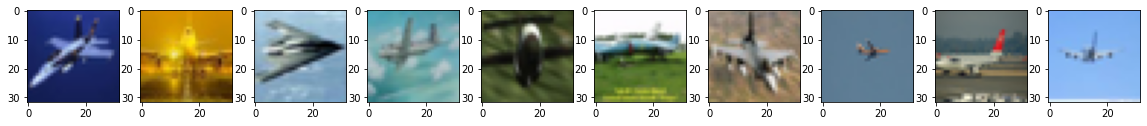

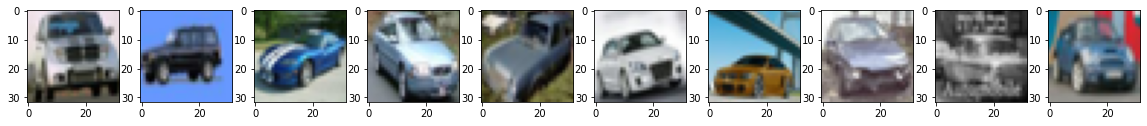

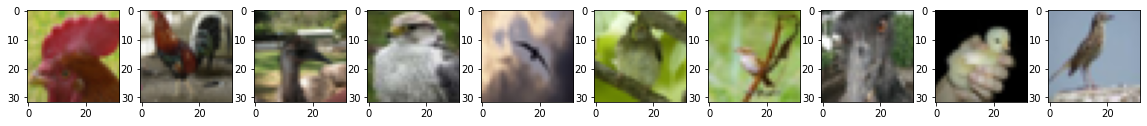

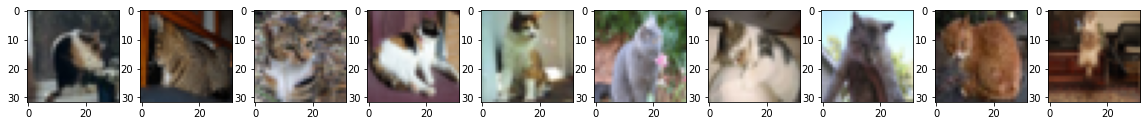

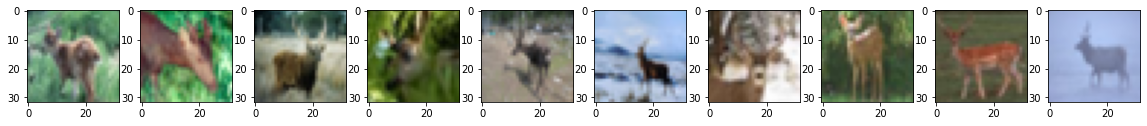

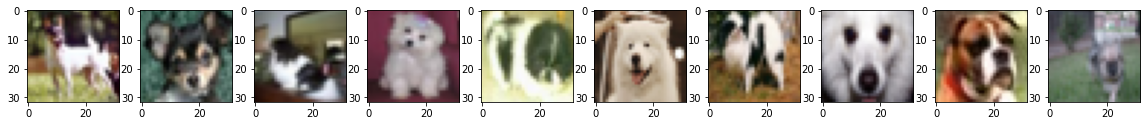

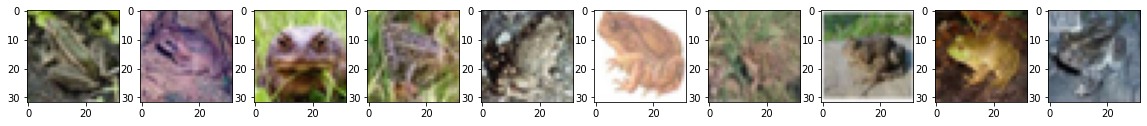

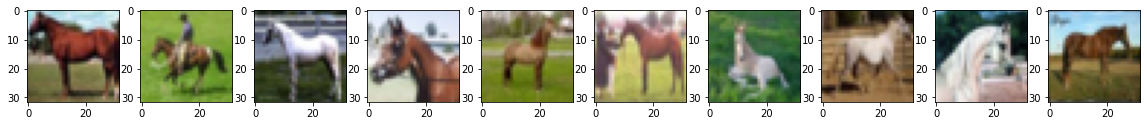

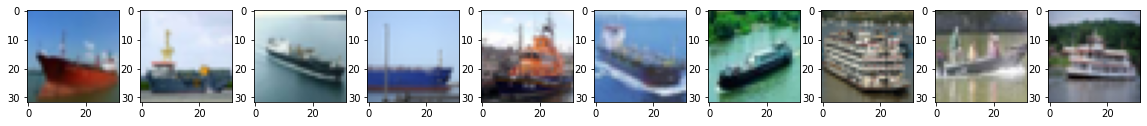

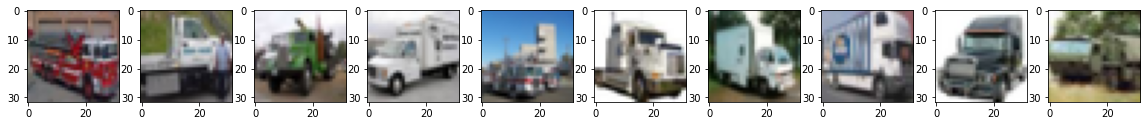

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_train.shape)

num_classes = 10
pos = 1

for target_class in range(num_classes):
    target_idx = []

    for i in range(len(y_train)):
        if y_train[i][0] == target_class:
            target_idx.append(i)
    
    np.random.shuffle(target_idx)
    plt.figure(figsize=(20,20))

    for idx in target_idx[:10]:
        plt.subplot(10, 10, pos)
        plt.imshow(X_train[idx])
        pos += 1

plt.show()


In [ ]:

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# データセットの読み込み
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 訓練用とテスト用の画像データを正規化する
x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
x_train, x_test = x_train/255.0, x_test/255.0
    
# 訓練データとテストデータの正解ラベルを10クラスのOne-Hot表現に変換
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

In [ ]:
"""
Define the model
"""

import tensorflow as tf

class CNN(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.conv2D_1 = tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=(3,3),
            padding="same",
            input_shape = (32,32,3), ############
            activation="relu",
        )
        self.conv2D_2 = tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=(3,3),
            padding="same",
            activation="relu",
        )
        self.pool1 = tf.keras.layers.MaxPooling2D(
            pool_size=(2,2)
        )
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.conv2D_3 = tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=(3,3),
            padding="same",
            activation="relu"
        )
        self.conv2D_4 = tf.keras.layers.Conv2D(
            filters=64,               # フィルターの数は64
            kernel_size=(3, 3),       # 3×3のフィルターを使用
            padding='same',           # ゼロパディングを行う
            activation='relu'         # 活性化関数はReLU
            )
        self.pool2 = tf.keras.layers.MaxPooling2D(
            pool_size=(2,2),
        )
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(
            512,
            activation="relu",
        )
        self.dropout3 = tf.keras.layers.Dropout(0.5)
        self.fc2 = tf.keras.layers.Dense(10, activation="softmax")
    
    @tf.function
    def call(self, x, training=None):
        x = self.conv2D_1(x)
        x = self.pool1(self.conv2D_2(x))

        if training:
            x = self.dropout1(x)

        x = self.conv2D_3(x)
        x = self.pool2(self.conv2D_4(x))

        if training:
            x = self.dropout2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        if training:
            x = self.dropout3(x)
        x = self.fc2(x)

        return x


In [ ]:
"""
set error function and optimizer
"""

import tensorflow as tf

loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
"""
update the parameter
"""

train_loss = tf.keras.metrics.Mean()
train_accuracy = tf.keras.metrics.CategoricalAccuracy()

@tf.function
def train_step(x, t):
    with tf.GradientTape() as tape:
        outputs = model(x, training=True)
        tmp_loss = loss_fn(t, outputs)

    grads = tape.gradient(
        tmp_loss,
        model.trainable_variables
    )
    optimizer.apply_gradients(
        zip(grads, model.trainable_variables)
    )
    train_loss(tmp_loss)
    train_accuracy(t, outputs) 

In [ ]:
val_loss = tf.keras.metrics.Mean()
val_accuracy = tf.keras.metrics.CategoricalAccuracy()

@tf.function
def valid_step(val_x, val_y):
    pred = model(val_x, training=False)
    tmp_loss = loss_fn(val_y, pred)
    val_loss(tmp_loss)
    val_accuracy(val_y, pred)

In [ ]:
'''
6. 学習の進捗を監視し早期終了判定を行うクラス
'''
class EarlyStopping:
    def __init__(self, patience=10, verbose=0):
        '''
        Parameters:
            patience(int): 監視するエポック数(デフォルトは10)
            verbose(int): 早期終了の出力フラグ
                          出力(1),出力しない(0)        
        '''
        # インスタンス変数の初期化
        # 監視中のエポック数のカウンターを初期化
        self.epoch = 0
        # 比較対象の損失を無限大'inf'で初期化
        self.pre_loss = float('inf')
        # 監視対象のエポック数をパラメーターで初期化
        self.patience = patience
        # 早期終了メッセージの出力フラグをパラメーターで初期化
        self.verbose = verbose
        
    def __call__(self, current_loss):
        '''
        Parameters:
            current_loss(float): 1エポック終了後の検証データの損失
        Return:
            True:監視回数の上限までに前エポックの損失を超えた場合
            False:監視回数の上限までに前エポックの損失を超えない場合
        '''
        # 前エポックの損失より大きくなった場合
        if self.pre_loss < current_loss:
            # カウンターを1増やす
            self.epoch += 1
            # 監視回数の上限を超えた場合
            if self.epoch > self.patience:
                # 早期終了のフラグが1の場合
                if self.verbose:
                    # メッセージを出力
                    print('early stopping')
                # 学習を終了するTrueを返す
                return True
        # 前エポックの損失より小さくならなかった場合
        else:
            # カウンターを0に戻す
            self.epoch = 0
            # 損失の値を更新する
            self.pre_loss = current_loss
        
        # 監視回数の上限を超えた直後に損失が改善されなければ
        # Falseを返して学習を続行する
        # 前エポックの損失を上回るが監視回数の範囲内であれば
        # Falseを返す必要があるので、return文の位置はここであることに注意
        return False

In [ ]:
from sklearn.model_selection import train_test_split

tr_x, val_x, tr_y, val_y = train_test_split(x_train, y_train, test_size=0.2)

In [9]:
%%time
'''
8.モデルを生成して学習する
'''
from sklearn.utils import shuffle

# エポック数
epochs = 200
# ミニバッチのサイズ
batch_size = 64
# 訓練データのステップ数
tr_steps = tr_x.shape[0] // batch_size
# 検証データのステップ数
val_steps = val_x.shape[0] // batch_size

# CNNのモデルを生成
model = CNN()
# 損失と精度の履歴を保存するためのdictオブジェクト
history = {'loss':[],'accuracy':[], 'val_loss':[], 'val_accuracy':[]}

# 早期終了の判定を行うオブジェクトを生成
ers = EarlyStopping(patience=20, # 監視対象回数
                    verbose=1)  # 早期終了時にメッセージを出力

# 学習を行う
for epoch in range(epochs):

    # 学習するたびに、記録された値をリセット
    train_loss.reset_states()     # 訓練時における損失の累計
    train_accuracy.reset_states() # 訓練時における精度の累計
    val_loss.reset_states()       # 検証時における損失の累計
    val_accuracy.reset_states()   # 検証時における精度の累計

    # 訓練データと正解ラベルをシャッフル
    x_, y_ = shuffle(tr_x, tr_y, )
    
    # 1ステップにおける訓練用ミニバッチを使用した学習
    for step in range(tr_steps):
        start = step * batch_size # ミニバッチの先頭インデックス
        end = start + batch_size  # ミニバッチの末尾のインデックス
        # ミニバッチでバイアス、重みを更新して誤差を取得
        train_step(x_[start:end], y_[start:end])

    # 1ステップにおける検証用ミニバッチを使用した評価
    for step in range(val_steps):
        start = step * batch_size # ミニバッチの先頭インデックス
        end = start + batch_size  # ミニバッチの末尾のインデックス
        # ミニバッチでバイアス、重みを更新して誤差を取得
        valid_step(val_x[start:end], val_y[start:end])

    avg_train_loss = train_loss.result()    # 訓練時の平均損失値を取得
    avg_train_acc = train_accuracy.result() # 訓練時の平均正解率を取得
    avg_val_loss = val_loss.result()     # 検証時の平均損失値を取得
    avg_val_acc = val_accuracy.result()  # 検証時の平均正解率を取得

    # 損失の履歴を保存する
    history['loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    # 精度の履歴を保存する
    history['accuracy'].append(avg_train_acc)
    history['val_accuracy'].append(avg_val_acc)

    # 1エポックごとに結果を出力
    if (epoch + 1) % 1 == 0:
        print(
            'epoch({}) train_loss: {:.4} train_acc: {:.4} val_loss: {:.4} val_acc: {:.4}'.format(
                epoch+1,
                avg_train_loss, # 現在の損失を出力
                avg_train_acc,  # 現在の精度を出力
                avg_val_loss,   # 現在の損失を出力
                avg_val_acc     # 現在の精度を出力
    ))
    
    # 検証データの損失をEarlyStoppingオブジェクトに渡して早期終了を判定
    if ers(val_loss.result()):
        # 監視対象のエポックで損失が改善されなければ学習を終了
        break

# モデルの概要を出力
model.summary()

epoch(1) train_loss: 1.698 train_acc: 0.3706 val_loss: 1.285 val_acc: 0.535
epoch(2) train_loss: 1.34 train_acc: 0.5129 val_loss: 1.222 val_acc: 0.5593
epoch(3) train_loss: 1.184 train_acc: 0.575 val_loss: 1.012 val_acc: 0.6456
epoch(4) train_loss: 1.101 train_acc: 0.6104 val_loss: 0.9432 val_acc: 0.6676
epoch(5) train_loss: 1.036 train_acc: 0.6327 val_loss: 0.891 val_acc: 0.691
epoch(6) train_loss: 0.9796 train_acc: 0.6532 val_loss: 0.8785 val_acc: 0.6878
epoch(7) train_loss: 0.9287 train_acc: 0.6698 val_loss: 0.837 val_acc: 0.704
epoch(8) train_loss: 0.9008 train_acc: 0.6821 val_loss: 0.7868 val_acc: 0.7301
epoch(9) train_loss: 0.8603 train_acc: 0.6947 val_loss: 0.774 val_acc: 0.7294
epoch(10) train_loss: 0.8327 train_acc: 0.7076 val_loss: 0.7542 val_acc: 0.7331
epoch(11) train_loss: 0.8085 train_acc: 0.7153 val_loss: 0.7506 val_acc: 0.7403
epoch(12) train_loss: 0.7871 train_acc: 0.7225 val_loss: 0.7571 val_acc: 0.7376
epoch(13) train_loss: 0.7696 train_acc: 0.7286 val_loss: 0.7421 v

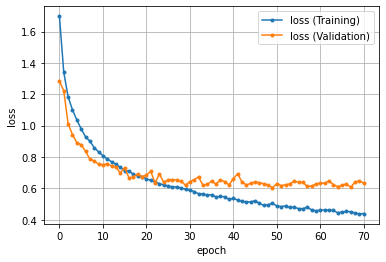

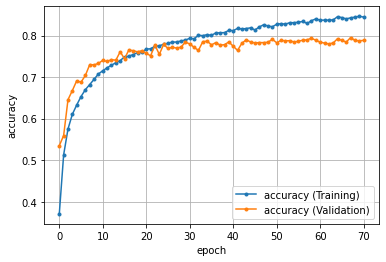

In [10]:
'''
9. 損失と精度の推移をグラフにする
'''
import matplotlib.pyplot as plt
%matplotlib inline

# 学習結果（損失）のグラフを描画
plt.plot(history['loss'],
         marker='.',
         label='loss (Training)')
plt.plot(history['val_loss'],
         marker='.',
         label='loss (Validation)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# 学習結果（精度）のグラフを描画
plt.plot(history['accuracy'],
         marker='.',
         label='accuracy (Training)')
plt.plot(history['val_accuracy'],
         marker='.',
         label='accuracy (Validation)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()